# <font color='green'>Metal-Organic Frame Materials Prediction</font>
___________________________
## Redes Neurais
___________________________
#### Alunos: Cauê Gomes Correia Santos, Izaque Junior Oliveira Silva e Karla Rovedo Pascoalini
#### Professor: Daniel Roberto Cassar
_____

**Resumo do Problema**

**De onde vieram nossos dados?**

**Features**

**Targets**

**O que são MOFs**

**O que utilizamos como base para o código**

____
**Montar o script**

<a id="sumario"></a>
## Sumário

[<font color='red'>[1] Adquirindo dados</font>](#adquirindodados)

[<font color='red'>[2] Analisando dados</font>](#analisededados)

[<font color='red'>[3] Tratamento de Dados</font>](#tratamentodedados)

[<font color='red'>[4] Reduzindo a Dimensionalidade</font>](#reduzindoadimensionalidade)

[<font color='red'>[5] Separando Target e Features</font>](#separandotargetefeatures)

[<font color='red'>[6] Implementação da Rede Neural</font>](#implementandoredeneural)

[<font color='red'>[7] Curva de Aprendizado</font>](#curvadeaprendizado)

[<font color='red'>[8] Otimização de Hiperparâmetros</font>](#otimizacaodehiperparametros)

[<font color='red'>[9] Cálculo RMSE</font>](#calculodermse)

[<font color='red'>[10] Conclusão</font>](#conclusao)

[<font color='red'>[11] Agradecimentos</font>](#agradecimentos)

[<font color='red'>[12] Referências bibliográficas</font>](#referencias)

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem as al
from rdkit.Chem import Draw, AllChem, Descriptors
from cod_izaque import converte
import numpy as np
from sklearn.model_selection import train_test_split
import lightning as L
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

import funcoes_metal_organic_predict as funcoes

<a id="adquirindodados"></a>
## 1-  Adquirindo Dados

___
[Voltar ao topo](#sumario)

Os nossos dados adveêm do site `Kaggle` e fazem parte da tarefa: `Metal-Organic Frame Materials Prediction`

In [2]:
dados_treino_finger = pd.read_csv(r"dados_treino\finger_train.csv", sep=',', header=0)
dados_treino_RAC = pd.read_csv(r"dados_treino\RAC_train.csv", sep=',', header=0)
dados_teste_RAC = pd.read_csv(r"dados_teste\RAC_test.csv", sep=',', header=0)
dados_teste_finger = pd.read_csv(r"dados_teste\finger_test.csv", sep=',', header=0)
dados_conf_ele_correct = pd.read_csv("electronic_configuration.csv", sep=',', header=0)

<a id="analisededados"></a>

## 2 - Análise de Dados
___
[Voltar ao topo](#sumario)

### Identificando Dados presentes em ambos DFs

In [3]:
intercecao_treino = funcoes.enc_intersection(dados_treino_finger['mof'].values, dados_treino_RAC['mof'].values)
intercecao_teste = funcoes.enc_intersection(dados_teste_finger['mof'].values, dados_teste_RAC['mof'].values)

In [4]:
#aplicando filtro para 
dados_fingertrain_filtrado = dados_treino_finger.loc[dados_treino_finger['mof'].isin(intercecao_treino)] #referncia: https://pt.stackoverflow.com/questions/309037/filtrar-linhas-no-pandas-por-uma-lista
dados_ractrain_filtrado = dados_treino_RAC.loc[dados_treino_RAC['mof'].isin(intercecao_treino)]
dados_fingertest_filtrado = dados_teste_finger.loc[dados_teste_finger['mof'].isin(intercecao_teste)] #referncia: https://pt.stackoverflow.com/questions/309037/filtrar-linhas-no-pandas-por-uma-lista
dados_ractest_filtrado = dados_teste_RAC.loc[dados_teste_RAC['mof'].isin(intercecao_teste)]

### Verificando o tipo de dado no DataFrame

In [5]:
dados_fingertrain_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 513
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mof              361 non-null    object 
 1   1s               361 non-null    int64  
 2   2s               361 non-null    int64  
 3   3s               361 non-null    int64  
 4   4s               361 non-null    int64  
 5   5s               361 non-null    int64  
 6   6s               361 non-null    int64  
 7   7s               361 non-null    int64  
 8   2p               361 non-null    int64  
 9   3p               361 non-null    int64  
 10  4p               361 non-null    int64  
 11  5p               361 non-null    int64  
 12  6p               361 non-null    int64  
 13  3d               361 non-null    int64  
 14  4d               361 non-null    int64  
 15  5d               361 non-null    int64  
 16  6d               361 non-null    int64  
 17  4f              

In [6]:
dados_ractrain_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 534
Columns: 354 entries, mof to additive_category
dtypes: float64(260), int64(93), object(1)
memory usage: 1001.2+ KB


In [7]:
dados_fingertest_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mof              134 non-null    int64 
 1   1s               134 non-null    int64 
 2   2s               134 non-null    int64 
 3   3s               134 non-null    int64 
 4   4s               134 non-null    int64 
 5   5s               134 non-null    int64 
 6   6s               134 non-null    int64 
 7   7s               134 non-null    int64 
 8   2p               134 non-null    int64 
 9   3p               134 non-null    int64 
 10  4p               134 non-null    int64 
 11  5p               134 non-null    int64 
 12  6p               134 non-null    int64 
 13  3d               134 non-null    int64 
 14  4d               134 non-null    int64 
 15  5d               134 non-null    int64 
 16  6d               134 non-null    int64 
 17  4f               134 non-null    in

In [8]:
dados_ractest_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Columns: 342 entries, mof to CH4HPSTP
dtypes: float64(255), int64(87)
memory usage: 359.1 KB


### Encontrando os dados `object` e convertendo

In [9]:
dados_fingertrain_filtrado.select_dtypes(include='object')

,mof,metal,linker1smi
0,WIRMOB_clean,Zn,O=C(O)c1ccc(COc2c3c(c(OCc4ccc(C(=O)O)cc4)c4c2C...
1,VIXTUT_clean,Zn,c1cc(CCc2ccncc2)ccn1
2,PODKUQ_clean,Cu,O=C(O)c1cc(C(=O)O)cc(-n2cc(-c3ccc(-c4cc(-c5ccc...
3,IKUTOZ_clean,Dy,O=C(O)c1c2ccccc2c(C(=O)O)c2ccccc12
4,LADHEF_clean,Zn,c1nnc[nH]1
...,...,...,...
507,LIKGUJ_clean,Cu,O=C1OC(=O)C2=C3C1=CC1C(=O)OC(=O)C4=C1C3C1=C(C4...
508,ZALMIL_clean,Co,O=C(O)C1CC(C(=O)O)C(C(=O)O)CC1C(=O)O
509,BINROH_clean,Cu,O=C(O)c1ccc2cc(-c3cc(-c4ccc5cc(C(=O)O)ccc5c4)c...
511,TAGTUT_clean,Mg,O=C(O)c1ccc2cc(C(=O)O)ccc2c1


In [10]:
dados_fingertest_filtrado.select_dtypes(include='object')

,metal,linker1smi
0,Zn,Nc1ncnc2nc[nH]c12
1,Cu,O=C(O)c1cc(C(=O)O)cc(-c2cc(-c3cc(C(=O)O)cc(C(=...
2,Mg,O=C(O)c1ccc2cc(C(=O)O)ccc2c1
3,Gd,O=C(O)c1ccc2[nH]c(-c3ccc(-c4nc5ccc(C(=O)O)cc5[...
4,Cu,O=C(O)c1cncc(C(=O)O)c1
...,...,...
129,Fe,[O-]C(=O)C1=[C]C2=C(S1)C1=[C]C(=[C]C1=C1[C]2[C...
130,Fe,[O-]C(=O)c1cc(C=Cc2cc(cc(c2)C(=O)O)C(=O)[O-])c...
131,Mn,[O-]C(=O)c1ccc(cc1)[Si](c1ccc(cc1)C(=O)[O-])(c...
132,Cd,[O-]C(=O)c1ccc(cc1)[Si](c1ccc(cc1)C(=O)[O-])(c...


In [11]:
dados_ractrain_filtrado.select_dtypes(include='object')

,mof
0,QUHMOX_clean
1,VOLPET_clean
2,XUHVON_clean
3,KIDDOS_clean
4,FURFOP_clean
...,...
530,YIPDOR_clean
531,EREGOY_clean
532,MAYKOO_clean
533,ADASEF_clean


As colunas que o pandas identifica como do tipo `object` são todas do tipo `string`. Vamos convertê-las.

In [12]:
lista = ['mof', 'metal', 'linker1smi']

In [13]:
funcoes.converte_datatype(dados_fingertrain_filtrado, lista, 'string')
funcoes.converte_datatype(dados_fingertest_filtrado, lista[1:], 'string')
funcoes.converte_datatype(dados_ractrain_filtrado, lista[:1], 'string')

C:\Users\izaque23003\OneDrive - ILUM ESCOLA DE CIÊNCIA\backup\Área de Trabalho\eu_ilum\trabalho_redes_neurais\Metal-Organic-Prediction\funcoes_metal_organic_predict.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = df[coluna].astype(type_converte)


### Verificando presença de dados não preenchidos

In [14]:
print(list(dados_fingertrain_filtrado.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
print(list(dados_fingertest_filtrado.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
print(list(dados_ractrain_filtrado.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
print(list(dados_ractest_filtrado.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<a id="tratamentodedados"></a>
## 3 - Tratamento de Dados
___
[Voltar ao topo](#sumario)

### Antes da diversão, alguns ajustes...

Para a implementação do `VIF` é necessário dados numéricos e nosso dataset possui uma mescla de dados str e dados int/float. Alguns dados str/object devem ser mantidos e para isso vamos realizar uma conversão simbólico-numérico, este é o caso do `metal`. A coluna `linker1smi` será transformada em um número com o auxílio da biblioteca `rdkit` com o módulo `Chem`.

In [18]:
lista_rac = list(dados_ractrain_filtrado.columns)
lista_rac.remove('mof')

In [19]:
lista= list(dados_fingertrain_filtrado.columns)
lista.remove('mof')

In [20]:
lista_teste = list(dados_fingertest_filtrado.columns)
lista_teste.remove('mof')

In [21]:
lista_rac_teste = list(dados_ractest_filtrado)
lista_rac_teste.remove('mof')

In [22]:
treino_finger_cp = dados_fingertrain_filtrado[lista]
treino_rac_cp = dados_ractrain_filtrado[lista_rac]
teste_finger_cp = dados_fingertest_filtrado[lista_teste]
teste_rac_cp = dados_ractest_filtrado[lista_rac_teste]

## <font color='red'>Atenção!</font>
Os códigos abaixo que dizem respeito à exploração dos dados contidos na coluna `linker1smi` foram baseados nos códigos de um usuário do KAGGLE `Marquis03`.

Como era de se imaginar, ele adicionou uma coluna para cada bit do fingerprint. Sabendo que todas as informações que necessitamos foram recolhidas, não vejo a necessidade de aumentar tanto o número de `Features` do nosso dataset.

def stri_to_mol(df, with_linker1smi=False):
    
    if with_linker1smi==False:
        #print('Estou no if false')
        molecula = df['linker1smi'].apply(Chem.MolFromSmiles)
        df = df.drop('linker1smi', axis=1)
        df = df.drop('metal', axis=1)
        #print('Df antes de novos_parametros', df) #debug
        parametros_novos(df, molecula)
        #print('Df depois de novos_parametros', df)#debug
    if with_linker1smi==True:
        
        molecula = df['linker1smi'].apply(Chem.MolFromSmiles)
        df =df.drop('metal', axis=1)
        fingerprint = lambda x: al.GetMorganFingerprintAsBitVect(x, 3)
        #baseado no código do Marquis03
        fingerprint1 = np.array(molecula.apply(fingerprint).tolist())             
        fingerprint1 = pd.DataFrame(fingerprint1).add_prefix("fp1_")
        fingerprint1.index = df.index
        df =df.drop('linker1smi', axis=1)
        df = pd.concat([df, fingerprint1], axis=1)
        #Fim
        parametros_novos(df, molecula)
    
    return df
    
def parametros_novos(df, molecula):
    df['Peso Molecula'] = molecula.apply(Descriptors.ExactMolWt)
    df['TPSA'] = molecula.apply(Chem.rdMolDescriptors.CalcTPSA) #Total Superficial Polar Area
    df['HBA'] = molecula.apply(Chem.rdMolDescriptors.CalcNumHBA) #Hidrogen bond acceptors
    df['HBD'] = molecula.apply(Chem.rdMolDescriptors.CalcNumHBD) #Hidrogen bond donnors
    df['LogP'] = molecula.apply(Descriptors.MolLogP) #calculus the hidrophobicity
    df['RotnBond'] = molecula.apply(Chem.rdMolDescriptors.CalcNumRotatableBonds) #calculus the number of rotation bonds

In [23]:
treino_finger_with_linker = treino_finger_cp.copy()
teste_finger_with_linker = teste_finger_cp.copy()

In [24]:
treino_finger_cp = funcoes.stri_to_mol(treino_finger_cp)
teste_finger_cp = funcoes.stri_to_mol(teste_finger_cp)
treino_finger_with_linker = funcoes.stri_to_mol(treino_finger_with_linker, with_linker1smi =True)
teste_finger_with_linker = funcoes.stri_to_mol(teste_finger_with_linker, with_linker1smi =True)

Com os valores de `linker1smi` convertidos, temos agora todas as informações sobre cada molécula presente no `dataset`. Do código que nos baseamos, ele adicionava os dados do array do `fingerprint` como colunas separadamente. Vamos tentar partir de outro ponto, nós vamos retirar a coluna `linker1smi` e realizar o VIF para diminuir a multicolinearidade e o número de dimensões.

<a id="reduzindoadimensionalidade"></a>
## 4 - Reduzindo a Dimensionalidade com o VIF
___
[Voltar ao topo](#sumario)

In [27]:
#Créditos: Daniel Roberto Cassar
from sklearn.linear_model import LinearRegression

def selecao_vif(df_atributos, limiar_vif):
    """Realiza a seleção de atributos por VIF.

    Args:
      df_atributos: DataFrame contendo os atributos.
      limiar_vf: valor do limiar do vif. Número positivo. Usualmente é 5 ou 10.

    Returns:
      DataFrame com os atributos selecionados.
    """

    df = df_atributos.copy()

    while True:
        VIFs = []

        for col in df.columns:
            X = df.drop(col, axis=1).values
            y = df[col].values

            r_quadrado = LinearRegression().fit(X, y).score(X, y)

            if r_quadrado != 1:
                VIF = 1 / (1 - r_quadrado)
            else:
                VIF = float("inf")

            VIFs.append(VIF)

        VIF_maximo = max(VIFs)

        if VIF_maximo > limiar_vif:
            indice = VIFs.index(VIF_maximo)
            coluna_remocao = df.columns[indice]
            df = df.drop(coluna_remocao, axis=1)
        else:
            break

    return df

In [25]:
#from cod_izaque import selecao_fif
#VIF para dados_treino_finger
LIMIAR_VIF = 5

VIF_treino_finger = funcoes.selecao_vif(treino_finger_cp, LIMIAR_VIF)

In [26]:
VIF_treino_finger #DATASET DE TREINO 1

,4s,3p,3d,4d,5d,4f,oxidation_state,temperature,time,HBA,HBD,LogP
0,2,6,10,0,0,0,2,110,72.0,4,2,10.21540
1,2,6,10,0,0,0,2,85,72.0,2,0,2.26180
2,1,6,10,0,0,0,2,80,24.0,15,6,8.61990
3,2,6,10,10,0,10,3,95,24.0,2,2,3.38940
4,2,6,10,0,0,0,2,80,72.0,2,1,-0.19530
...,...,...,...,...,...,...,...,...,...,...,...,...
507,1,6,10,0,0,0,2,65,48.0,9,0,-0.35750
508,2,6,7,0,0,0,2,140,72.0,4,4,-0.41660
509,1,6,10,0,0,0,2,90,24.0,3,3,9.24180
511,0,0,0,0,0,0,2,120,120.0,2,2,2.23620


In [27]:
#from cod_izaque import selecao_fif
#VIF para dados_treino_finger
LIMIAR_VIF = 5

VIF_teste_finger = funcoes.selecao_vif(teste_finger_cp, LIMIAR_VIF)

In [28]:
VIF_teste_finger #DATASET DE TESTE 1

,4s,6s,3p,6p,3d,4d,5d,oxidation_state,Peso Molecula,HBD,LogP,RotnBond
0,2,0,6,0,10,0,0,2,135.054495,2,-0.06490,0
1,1,0,6,0,10,0,0,2,570.079826,6,4.87680,9
2,0,0,0,0,0,0,0,2,216.042259,2,2.23620,2
3,2,2,6,0,10,10,1,3,398.101505,4,4.16960,4
4,1,0,6,0,10,0,0,1,167.021858,2,0.47800,2
...,...,...,...,...,...,...,...,...,...,...,...,...
129,2,0,6,6,0,0,0,3,351.915275,0,-2.03445,3
130,2,0,6,0,6,0,0,3,353.031388,1,-1.35430,6
131,0,0,6,0,5,0,0,2,508.063638,0,-3.48200,8
132,2,0,6,0,10,10,0,2,508.063638,0,-3.48200,8


<a id="separandotargetefeatures"></a>
## 5 - Separando `TARGET` e `FEATURES`
___
[Voltar ao topo](#sumario)

___
## <font color='red'>Atenção!</font>

Os códigos abaixo foram escritos/inspirados a partir dos códigos dos cadernos jupyter do professor Daniel Roberto Cassar$.^{[ref]}$
___

In [32]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.2
SEMENTE_ALEATORIA = 1234567890

In [36]:
colunas = list(VIF_treino_finger.columns)
colunas

['4s',
 '3p',
 '3d',
 '4d',
 '5d',
 '4f',
 'oxidation_state',
 'temperature',
 'time',
 'HBA',
 'HBD',
 'LogP']

In [37]:
features =['4s','3p','3d','4d','5d', '4f', 'time', 'HBA', 'HBD', 'LogP']
target = ['oxidation_state','temperature']

In [40]:
indices = VIF_treino_finger.index
indices_treino_val, indices_teste = train_test_split(indices, 
                                                    test_size=TAMANHO_TESTE, 
                                                    random_state=SEMENTE_ALEATORIA)
#separando dados holdout
finger_treino_val = VIF_treino_finger.loc[indices_treino_val]
finger_teste = VIF_treino_finger.loc[indices_teste]

FEATURES_teste = finger_teste.reindex(features, axis=1).values
TARGET_teste = finger_teste.reindex(target, axis=1).values

In [43]:
indices = finger_treino_val.index
indices_treino, indices_val = train_test_split(indices, 
                                            test_size=TAMANHO_TESTE, 
                                            random_state=SEMENTE_ALEATORIA)

finger_treino = VIF_treino_finger.loc[indices_treino]
finger_validacao = VIF_treino_finger.loc[indices_val]

FEATURES_treino = finger_treino.reindex(features, axis=1).values
TARGET_treino = finger_treino.reindex(target, axis=1).values

FEATURES_validacao = finger_validacao.reindex(features, axis=1).values
TARGET_validacao = finger_validacao.reindex(target, axis=1).values

### Normalização e Transformação em tensor

In [44]:
# NORMALIZANDO DE -1 a 1 PQ QUEREMOS GRANDEZAS QUE VALEM 0 CONTINUEM 0.
x_padrao = MaxAbsScaler()
x_padrao.fit(FEATURES_treino)

y_padrao = MaxAbsScaler()
y_padrao.fit(TARGET_treino)

FEATURES_treino = x_padrao.transform(FEATURES_treino)
TARGET_treino = y_padrao.transform(TARGET_treino)

FEATURES_validacao = x_padrao.transform(FEATURES_validacao)
TARGET_validacao = y_padrao.transform(TARGET_validacao)

FEATURES_teste = x_padrao.transform(FEATURES_teste)
TARGET_teste = y_padrao.transform(TARGET_teste)

In [45]:
# TORNANDO-O TENSOR
FEATURES_treino = torch.tensor(FEATURES_treino, dtype=torch.float32)
TARGET_treino = torch.tensor(TARGET_treino, dtype=torch.float32)

FEATURES_teste = torch.tensor(FEATURES_teste, dtype=torch.float32)
TARGET_teste = torch.tensor(TARGET_teste, dtype=torch.float32)

FEATURES_validacao = torch.tensor(FEATURES_validacao, dtype=torch.float32)
TARGET_validacao = torch.tensor(TARGET_validacao, dtype=torch.float32)

<a id="implementandoredeneural"></a>
## 6 - Implementação da Rede Neural
___
[Voltar ao topo](#sumario)

### `DataModule` Simplificado

In [46]:
class DataModule(L.LightningDataModule):  #PEGUEI DIRETO DO DANIEL
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

### Criando a Rede Neural com `Pytorch Lightning`

In [47]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios, num_saida, lr
    ):
        super().__init__()
        
        todas_as_camadas = []
        todas_as_camadas.append(nn.Linear(num_dados_entrada, neuronios[0]))
        todas_as_camadas.append(nn.ReLU())
        for i in range(len(neuronios)-1):
            camada = nn.Linear(neuronios[i], neuronios[i+1])
            todas_as_camadas.append(camada)
            todas_as_camadas.append(nn.ReLU())
        todas_as_camadas.append(nn.Linear(neuronios[-1], num_saida))

        self.camadas = nn.Sequential(*todas_as_camadas)

        self.fun_perda = F.mse_loss
        self.lr = lr

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        return optimizer

### Treinando a Rede

In [54]:
NUM_EPOCAS = 20
NUM_DADOS_DE_ENTRADA = 10
NUM_DADOS_DE_SAIDA = 2
neuPorCamada = [15, 50, 3]

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

dm = DataModule(FEATURES_treino, TARGET_treino, FEATURES_validacao, TARGET_validacao, FEATURES_teste, TARGET_teste) # CRIANDO INSTANCIA DATAMODULE

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, neuPorCamada, NUM_DADOS_DE_SAIDA, 1e-2)
# CRIANDO INSTÂNCIA DA REDE NEURAL

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
treinador.fit(minha_mlp, dm) #FITANDO E FORNECENDO (TAMBEM) UMA INSTANCIA DATAMODULE COMO
# ARGUMENTO


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


<a id="curvadeaprendizado"></a>
## 7 - Curva de Aprendizado
___
[Voltar ao topo](#sumario)

Text(0, 0.5, 'Loss')

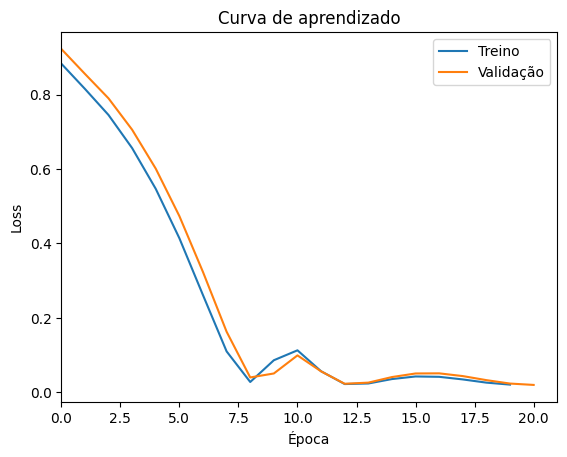

In [56]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")
#N VAI RODAR NO PCZINHO DA ILUM :(

<a id="otimizacaodehiperparametros"></a>
## 8 - Otimização de Hiperparâmetros
___
[Voltar ao topo](#sumario)

### Optuna - otimização de hiperparâmetros

In [57]:
dm = DataModule(FEATURES_treino, TARGET_treino, FEATURES_validacao, TARGET_validacao, FEATURES_teste, TARGET_teste) # CRIANDO INSTANCIA DATAMODUL

def objective(trial):
    camadas = trial.suggest_int('num_camadas', 1, 7)
    hidden = []
    for i in range(camadas):
        hidden.append(int(trial.suggest_int(f'neuronios_c{i}', 2, 70)))
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    
    treinador = L.Trainer(max_epochs=250,callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
    minha_MLP = MLP(15, hidden, 2, learning_rate)
    treinador.fit(minha_MLP, dm)
    
    return treinador.callback_metrics["val_loss"].item()


In [58]:
#Criando um objeto de estudo para salvar os hiperparâmetros encontrados pelo Optuna
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///db.sqlite3",
                            study_name="estudo1",load_if_exists=True
    )
study.optimize(objective, n_trials=3333200)

best_params = study.best_params
best_loss = study.best_value

print("Melhores hiperparâmetros encontrados:", best_params)
print("Melhor perda -loss- encontrada:", best_loss)

NameError: name 'optuna' is not defined

In [58]:
#Criando dataset
dmFinal = DataModule(FEATURES_treino, TARGET_treino, FEATURES_validacao, TARGET_validacao, FEATURES_teste, TARGET_teste) # CRIANDO INSTANCIA DATAMODUL


#Importando estudo

study = optuna.create_study(direction='minimize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="estudo1",load_if_exists=True
    )

best_params = study.best_params
best_loss = study.best_value

# Testando a rede com os melhores hiperparâmetros encontrados

camadas = [best_params[f"neuronios_c{i}"] for i in range(2)]
lr = best_params["learning_rate"]

#Treinando o teste

treinador = L.Trainer(max_epochs=200)
minha_MLP2 = MLP(15, camadas, 2, lr)

treinador.fit(minha_MLP2, dmFinal)

[I 2024-05-25 09:50:21,426] Using an existing study with name 'estudo1' instead of creating a new one.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.7 K 
---------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


MLP(
  (camadas): Sequential(
    (0): Linear(in_features=15, out_features=62, bias=True)
    (1): ReLU()
    (2): Linear(in_features=62, out_features=27, bias=True)
    (3): ReLU()
    (4): Linear(in_features=27, out_features=2, bias=True)
  )
)


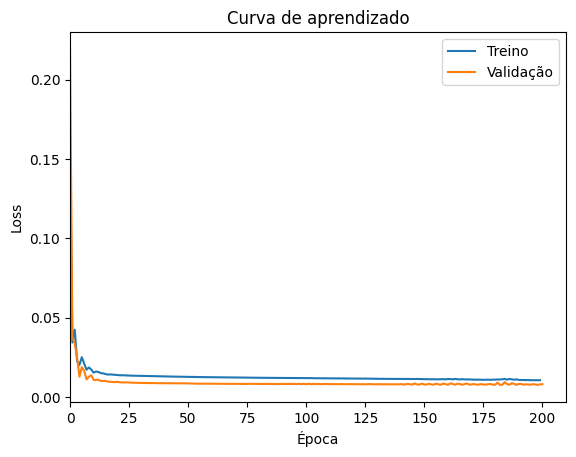

In [59]:
print(minha_MLP2)

# Plotando curva de aprendizado

figura, eixo = plt.subplots()

ca_treino = minha_MLP2.curva_aprendizado_treino
ca_val = minha_MLP2.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

<a id="calculodermse"></a>
## 9 - Cálculo de RMSE
___
[Voltar ao topo](#sumario)

In [ ]:
minha_mlp.eval()

In [ ]:
#NÃO COMPUTA GRADIENTE LOCAL
#COMPUTA: VALOR PREVISTO DO TARGET E DESNORMALIZA OS DADOS

dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = y_padrao.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = y_padrao.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

In [60]:
minha_MLP2.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=15, out_features=62, bias=True)
    (1): ReLU()
    (2): Linear(in_features=62, out_features=27, bias=True)
    (3): ReLU()
    (4): Linear(in_features=27, out_features=2, bias=True)
  )
)

In [61]:
best_params = study.best_params
best_loss = study.best_value

print(best_params)

{'learning_rate': 0.005766773710912289, 'neuronios_c0': 62, 'neuronios_c1': 27, 'neuronios_c2': 49, 'num_camadas': 3}


In [68]:
minha_MLP2.eval()

with torch.no_grad():
    X_true = FEATURES_teste

    y_true = TARGET_teste
    y_true = y_padrao.inverse_transform(y_true)

    y_pred = minha_MLP(X_true)
    y_pred = y_padrao.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    
    print("O RMSE calculado foi de:", RMSE)
    

O RMSE calculado foi de: 45.773886191856604


<a id="conclusao"></a>
# 10 - Conclusão
___
[Voltar ao topo](#sumario)

<a id="agradecimentos"></a>
# 11 - Agradecimentos
___
[Voltar ao topo](#sumario)

<a id="referencias"></a>
# 12 - Referências Bibliográficas
___
[Voltar ao topo](#sumario)